In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import analysis_utils as au
import simulation_utils as su
import importlib

In [2]:
# Define some parameters

w0 = 55000*2*np.pi # Natural frequency of oscillator
P = 1*10**(-7) # Pressure in mbar
T = 293 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
dtn = 1*10**(-8) # Timestep
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
P0 = 1000 # Ambient pressure
N=N0*P/P0 # Number density of air at pressure P

y = (4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air
#y = 4.10568*1e-6*P*1e2/R # Antonio's damping from air

print(y)

Snn = 10**(-28) # Displacement noise

0.00029717080823618027


In [33]:
maxw = 5*10**5 # 500 kHz is enough to capture all dynamics
yfb = 1*2*np.pi
numbins = int(2*5*10**4*100*2*np.pi/yfb) # This is to ensure the particle amplitude decays to thermal levels
w = np.linspace(0, maxw*2*np.pi, numbins)

# Generate some random number seeds
np.random.seed(85655219)
random_nums = np.random.uniform(0, 1000000, 3) # These are the seeds we will use

randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[0:3], Snn, numbins, maxw)
x = su.generate_displacement_fm(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, np.zeros(numbins), 0.01, 0)

In [93]:
randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[0:3], Snn, numbins, maxw)
x = np.sin(55000*2*np.pi*np.linspace(0, 10, 10**7)) + randomlist3

In [34]:
PSD = scisig.welch(x, fs = 10**6, nperseg = 10**6, window = 'boxcar')

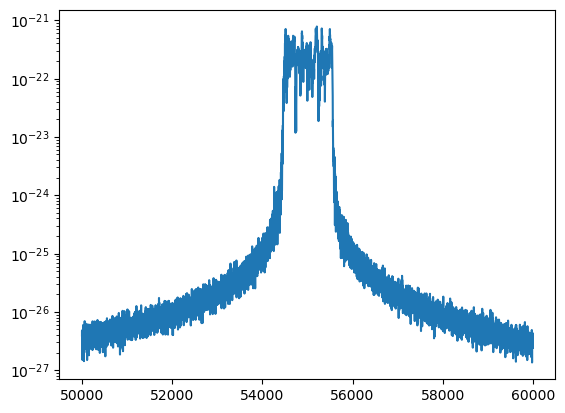

In [35]:
lb = int(1*50000)
ub = int(1*60000)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.yscale('log')

In [36]:
time, R2, R2_filt, theta_filt = au.lockin(x[:10**7], 10**6, 55000, 10000, 20000, 10, 'R')

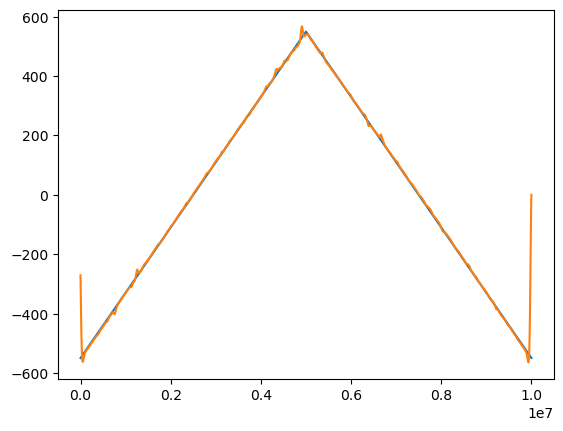

In [37]:
lb = 0
ub = -1
mod = su.generate_sawtooth_frequency_modulation_impulse(np.linspace(0, 10, 10**7), 0.01, 0)
plt.plot(mod*55000-55000)
plt.plot(np.gradient(theta_filt, 10**(-6))[lb:ub]/2/np.pi)

In [38]:
w_est = np.gradient(theta_filt, 10**(-6))[lb:ub]/2/np.pi/55000+1

In [39]:
theta_est = []
area = 0
for i in range(len(w_est)):
    area += np.trapz(w_est[i:i+2], np.linspace(10**(-6)*i, 10**(-6)*(i+2), 2))
    theta_est.append(area)

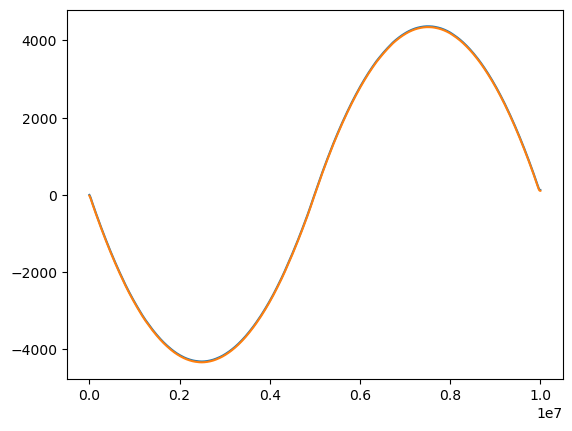

In [46]:
plt.plot(np.array(theta_est)*2*np.pi/2)
plt.plot(theta_filt)

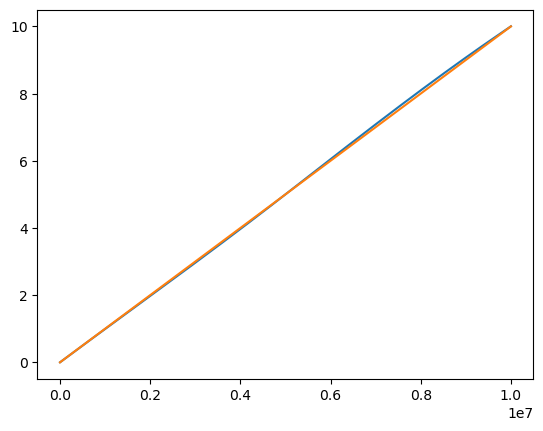

In [51]:
time = np.linspace(1*10**(-6), 10, 10**7-1)
plt.plot((theta_filt/2/np.pi/55000+1)*time)
plt.plot(time)

In [ ]:
x_mod = frequency_modulation(x, (theta_filt/2/np.pi/55000+1)*time, time)

In [52]:
time2 = su.generate_sawtooth_frequency_modulation(np.linspace(0, 10, 10**7), 0.01, 0)
mod = su.generate_sawtooth_frequency_modulation_impulse(np.linspace(0, 10, 10**7), 0.01, 0)

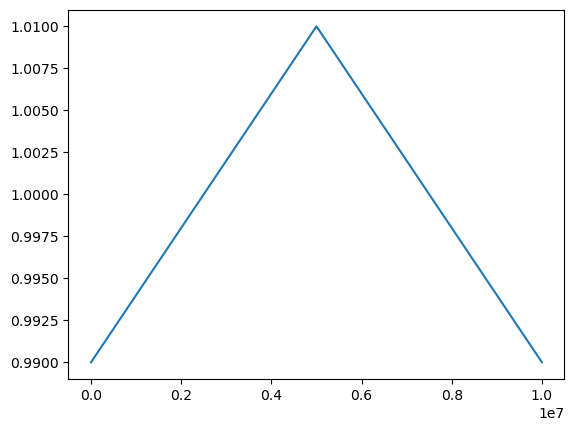

In [53]:
plt.plot(mod)

In [54]:
foo = []
area = 0
for i in range(len(mod)):
    area += np.trapz(mod[i:i+2], np.linspace(10**(-6)*i, 10**(-6)*(i+2), 2))
    foo.append(area)

In [55]:
plt.plot(foo)

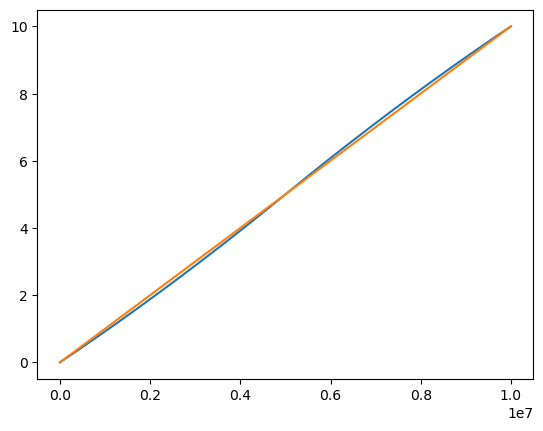

In [ ]:

plt.plot(np.array(foo)/2)
plt.plot(np.linspace(0, 10, 10**7))
#plt.plot(time2)

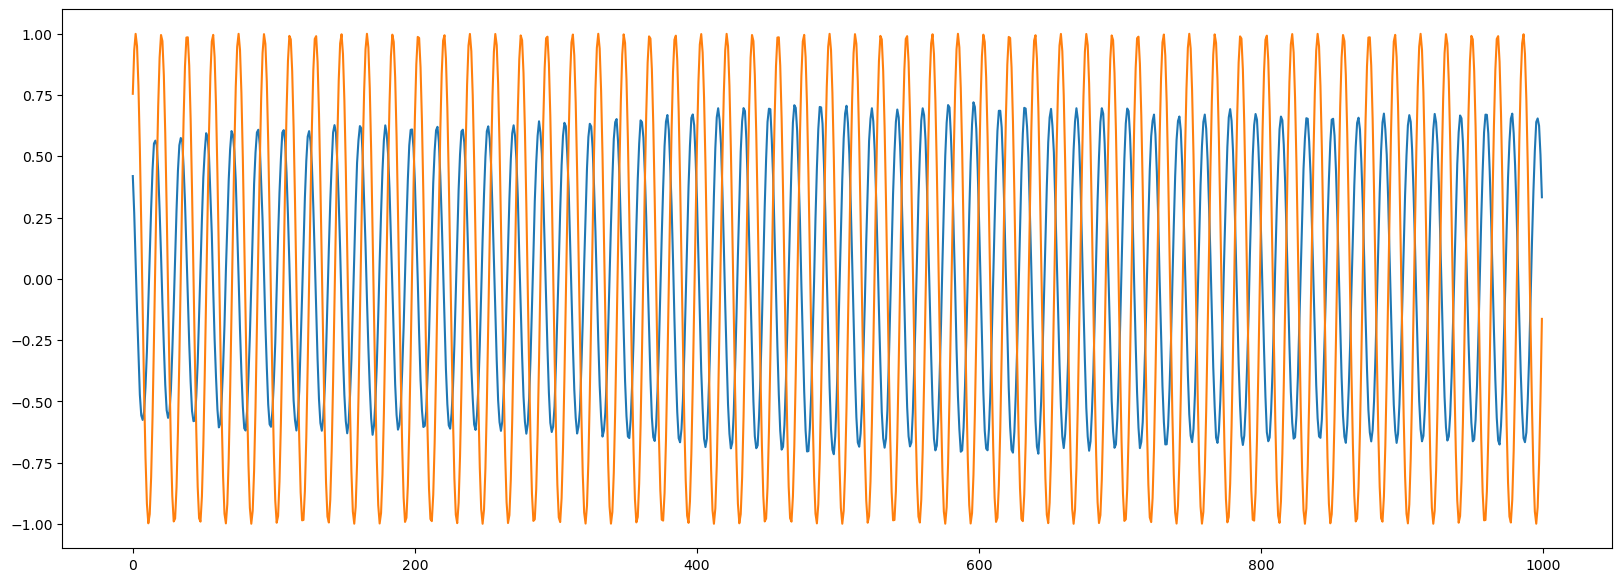

In [59]:
lb = -int(8*10**6)
ub = lb+1000 
plt.figure(figsize = (20, 7))
plt.plot(x[lb:ub]*10**9)
#plt.plot(np.sin((55000*2*np.pi+theta_filt[:-1]+(theta_filt[1:] - theta_filt[:-1])*10**6)*np.linspace(2*10**(-6), 10, 10**7-2))[lb:ub])
plt.plot(np.sin((55000*2*np.pi)*np.linspace(1*10**(-6), 10, 10**7-1)+theta_filt)[lb:ub])

In [100]:
np.std((theta_filt[1:] - theta_filt[:-1])*10**6/2/np.pi/2)

0.26801164045959797